# 저장된 ckp 파일에서 confusion matrix 뽑기

In [1]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader
from load_data import *
import pandas as pd
import torch
import torch.nn.functional as F
import json
import pickle as pickle
import numpy as np
import argparse
from tqdm import tqdm

from inference import *
from train import label_to_num

/opt/conda/envs/klue/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# load_parameter: tokenizer, sentence preprocessing
tokenize_function_list = {"default": tokenized_dataset}
with open("config.json","r") as js:
    config = json.load(js)
    load_model = config['model_name']        # model
    filter = config['sentence_filter']       # sentence_filter
    marking_mode = config['marking_mode']    # marking_mode
    tokenize_mode = config['tokenize_mode'] # tokenize_function
print("####################################################################################################################\n",
    f"Model_name: {load_model}, Filter: {filter}, Marking_mode: {marking_mode}, Tokenized_function: {tokenize_mode}\n",
    "####################################################################################################################\n")

# load tokenizer
Tokenizer_NAME = load_model
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

# add_vocab
with open("marking_mode_tokens.json","r") as json_file:
    mode2special_token = json.load(json_file)
if marking_mode != "normal" and  marking_mode != "typed_entity_punc":
    tokenizer.add_special_tokens({"additional_special_tokens":mode2special_token[marking_mode]})

## load my model
### confusion matrix를 뽑을 ckp파일 경로를 설정해주세요!!!!!
# ckp_dir = "/opt/ml/level2-klue-level2-nlp-09-old/results/checkpoint-4000"
ckp_dir = "./results/checkpoint-3500"
model =  AutoModelForSequenceClassification.from_pretrained(ckp_dir)
# model.parameters
model.to(device)

####################################################################################################################
 Model_name: klue/roberta-large, Filter: False, Marking_mode: normal, Tokenized_function: default
 ####################################################################################################################



RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [3]:
dataset_dir = "../dataset/train/train.csv"
train_dataset, dev_dataset = load_data(dataset_dir, train=True, filter=filter, marking_mode=marking_mode)

# train_label = label_to_num(train_dataset['label'].values)
# tokenized_train = tokenized_dataset(train_dataset, tokenizer, tokenize_mode)
# RE_train_dataset = RE_Dataset(tokenized_train, train_label)

# valid dataset으로만 confusion matrix 추출
dev_label = label_to_num(dev_dataset['label'].values)
tokenized_dev = tokenized_dataset(dev_dataset, tokenizer, tokenize_mode)
RE_dev_dataset = RE_Dataset(tokenized_dev, dev_label)

pred_answer, output_prob = inference(model, RE_dev_dataset, device) # model에서 class 추론

100%|██████████| 406/406 [03:25<00:00,  1.98it/s]


In [4]:
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

label_list = ['no_relation', 'org:top_members/employees', 'org:members',
            'org:product', 'per:title', 'org:alternate_names',
            'per:employee_of', 'org:place_of_headquarters', 'per:product',
            'org:number_of_employees/members', 'per:children',
            'per:place_of_residence', 'per:alternate_names',
            'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
            'per:spouse', 'org:founded', 'org:political/religious_affiliation',
            'org:member_of', 'per:parents', 'org:dissolved',
            'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
            'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
            'per:religion']

val_labels = dev_dataset['label']
val_nums = label_to_num(val_labels)  # 정답 str 라벨값으로 변환

val_nums_arr = np.array(val_nums)
pred_answer_arr = np.array(pred_answer)

cm = metrics.confusion_matrix(val_nums_arr, pred_answer_arr)
cm_ans = metrics.confusion_matrix(val_nums_arr, val_nums_arr)

## 개수별로 보기

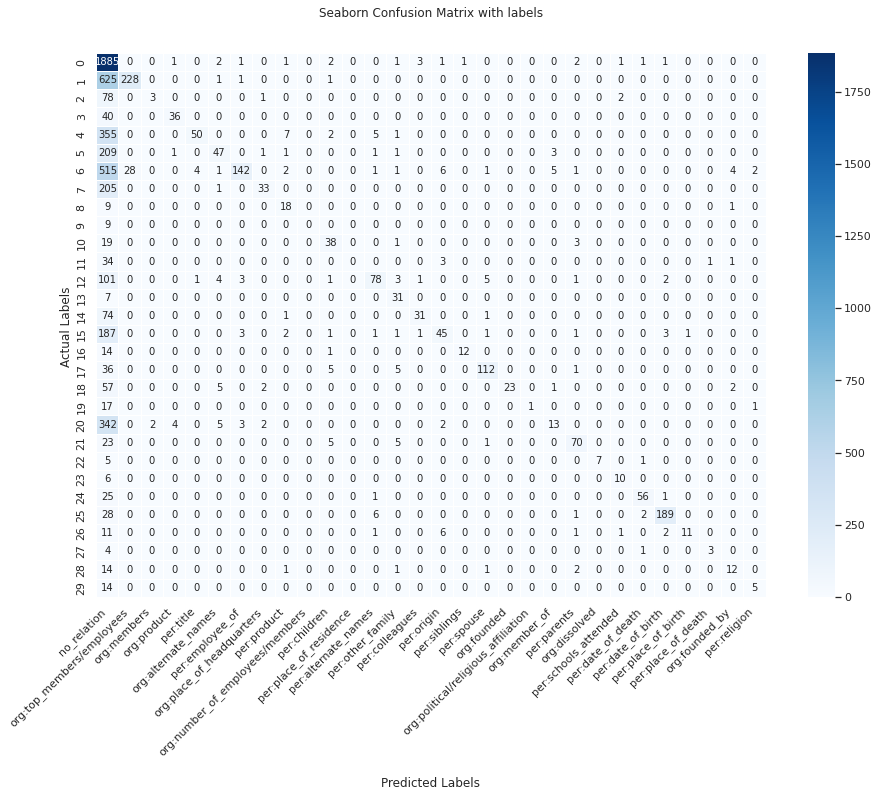

In [5]:
# plot
# sns.set(rc={'figure.figsize':(17, 15)})
sns.set(rc={'figure.figsize':(15, 10)})

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt="d",
                linewidths=.5, 
                annot_kws={"size": 10})
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('Actual Labels ');

ax.xaxis.set_ticklabels(label_list, rotation=45, ha="right")
plt.show()

## 정규화한 confusion matrix

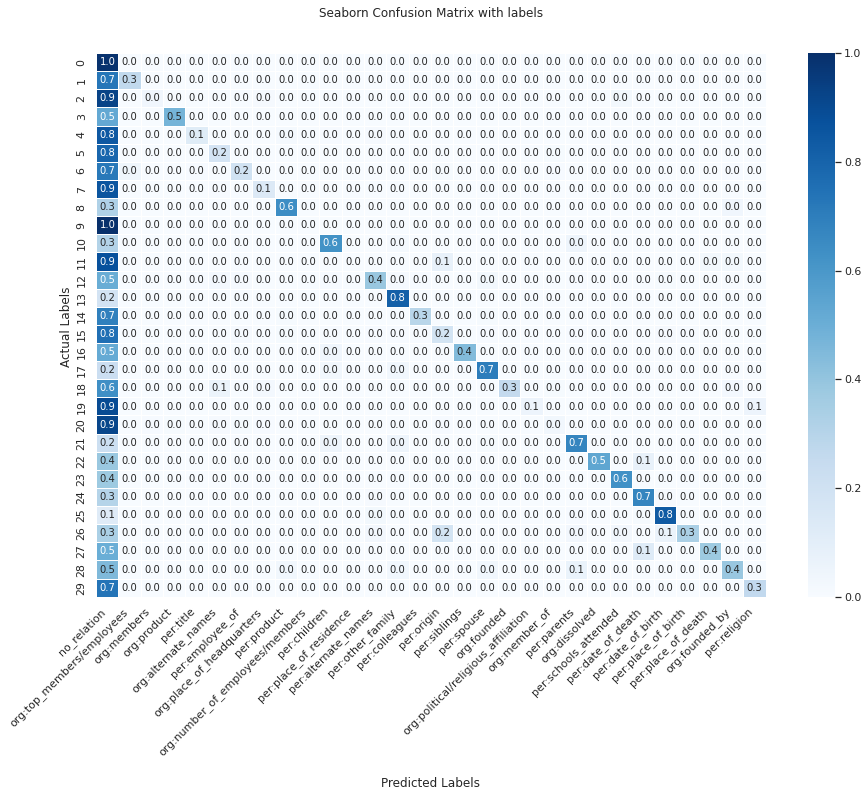

In [6]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_ans = cm_ans.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# plot
# sns.set(rc={'figure.figsize':(17, 15)})
sns.set(rc={'figure.figsize':(15, 10)})

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt=".1f",
                linewidths=.5, 
                annot_kws={"size": 10},
                vmin = 0.0, vmax = 1.0)
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('Actual Labels ');
# ax.set_xlim(0, 1)

ax.xaxis.set_ticklabels(label_list, rotation=45, ha="right")
plt.show()

In [7]:
# precision, recall, f1-score 출력

print(classification_report(val_nums, pred_answer, target_names=label_list))

                                     precision    recall  f1-score   support

                        no_relation       0.38      0.99      0.55      1903
          org:top_members/employees       0.89      0.27      0.41       856
                        org:members       0.60      0.04      0.07        84
                        org:product       0.86      0.47      0.61        76
                          per:title       0.91      0.12      0.21       420
                org:alternate_names       0.71      0.18      0.28       264
                    per:employee_of       0.93      0.20      0.33       713
          org:place_of_headquarters       0.85      0.14      0.24       239
                        per:product       0.55      0.64      0.59        28
    org:number_of_employees/members       0.00      0.00      0.00         9
                       per:children       0.68      0.62      0.65        61
             per:place_of_residence       0.00      0.00      0.00        3

/opt/conda/envs/klue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/klue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/klue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
